# Objective: Implement Word2Vec from scratch using CBOW
- initialise and prepare data from randomly generated words
- train model using pytorch lightning
- extract learned embedding from model

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader , random_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## Set up training data

In [29]:
dog_cat_words = ['dog', 'cat', 'pet', 'house', 'animal', 'sleep', 'play']
family_words = ['girl', 'boy', 'father', 'mother', 'family', 'house', 'marriage']
king_queen_words = ['crown', 'queen', 'king', 'empire', 'country', 'rule', 'castle']

dog_cat_text = ''
family_text = ''
king_queen_text = ''

for _ in range(10_000):
    random.shuffle(dog_cat_words)
    dog_cat_text = dog_cat_text + ' ' + ' '.join(dog_cat_words)
    random.shuffle(family_words)
    family_text = family_text + ' ' + ' '.join(family_words)
    random.shuffle(king_queen_words)
    king_queen_text = king_queen_text + ' ' + ' '.join(king_queen_words)

small_corpus = dog_cat_text + ' ' + family_text + ' ' + king_queen_text

# Extract the dataset
file_name = "../../datasets/nlp/small_corpus.txt"
with open(file_name, 'w') as file:
    file.write(small_corpus)       

In [30]:
file_path = '../../datasets/nlp/small_corpus.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

text

' play sleep cat house animal dog pet animal house cat dog play sleep pet dog play house sleep pet cat animal play cat animal dog pet house sleep play house sleep pet dog animal cat play animal house dog sleep pet cat house sleep animal pet play dog cat house cat pet sleep play dog animal cat pet sleep animal play house dog pet sleep house play cat animal dog animal sleep house dog play pet cat dog cat animal pet play house sleep animal cat house sleep pet dog play play house cat dog pet sleep animal animal house sleep play cat dog pet sleep house dog cat play animal pet sleep pet play cat dog animal house dog house sleep cat pet play animal cat dog pet house sleep play animal house cat dog pet play animal sleep pet play animal sleep house cat dog pet cat house sleep animal dog play sleep cat play house dog animal pet dog play house animal sleep pet cat play dog house animal sleep cat pet sleep cat pet dog animal play house dog house cat animal play sleep pet house play animal dog pet 

In [31]:
def extract_unique_words(text):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Count the number of words and unique words
    print("# of words in the text: ", len(words))

    unique_words = sorted(set(words))
    print("# of unqiue words in the text: ", len(unique_words))

    return unique_words

unique_words = extract_unique_words(text)

# of words in the text:  210000
# of unqiue words in the text:  20


## Initialise Trainer Class & Function

In [ ]:
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, weight_decay=1e-4):
        super().__init__()
        self.save_hyperparameters()  
        
        self.model = model
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.train_losses = []
        self.val_losses = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        context, target = batch
        predictions = self(context)
        loss = self.loss_fn(predictions, target)
        
        self.log('train_loss', loss, prog_bar=True)
        self.train_losses.append(loss.detach().cpu().item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        context, target = batch
        predictions = self(context)
        val_loss = self.loss_fn(predictions, target)
        
        self.log('val_loss', val_loss, prog_bar=True)
        self.val_losses.append(val_loss.detach().cpu().item())
        return val_loss
    
    def plot_losses(self):
        
        plt.figure(figsize=(10, 6))
        
        # Average train losses per epoch (simplified)
        if self.train_losses:
            plt.plot(range(len(self.train_losses)), self.train_losses, 
                    label='Train Loss')
        
        # Average val losses per epoch (simplified)
        if self.val_losses:
            # Assuming validation happens once per epoch
            val_epochs = range(0, len(self.val_losses))
            plt.plot(val_epochs, self.val_losses, 
                    label='Val Loss', linewidth=2)
        
        plt.xlabel('Steps/Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        return optimizer

In [33]:
def train_model(model,train,val,epochs=10):
    lightning_model = LightningModel(model)

    early_stop_callback = EarlyStopping(
        monitor='val_loss',           
        min_delta=0.00,              
        patience=3,                  
        verbose=True,                
        mode='min'                  
    )

    trainer = pl.Trainer(
        max_epochs=epochs,
        callbacks=[early_stop_callback],
        accelerator='auto',  
        devices='auto',
        precision=16,  
        accumulate_grad_batches=4,  
        gradient_clip_val=1.0, 
        logger=False,
        enable_checkpointing=False,
    )

    trainer.fit(lightning_model, train , val)

    return lightning_model


In [34]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample, output_sample

## CBOW Word2Vec

In [35]:
def generate_cbows(text, window_size):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Create CBOW pairs with a given window size
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

cbows = generate_cbows(text, window_size=3)
print(len(cbows))

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Context Words: {context_words}, Target Word: {target_word}')

209994
Context Words: ['play', 'sleep', 'cat', 'animal', 'dog', 'pet'], Target Word: house
Context Words: ['sleep', 'cat', 'house', 'dog', 'pet', 'animal'], Target Word: animal
Context Words: ['cat', 'house', 'animal', 'pet', 'animal', 'house'], Target Word: dog


In [36]:
def one_hot_encoding(word, unique_words):
    encoding = [1 if word == w else 0 for w in unique_words]
    return torch.tensor(encoding, dtype=torch.float32)

# Create one-hot encodings for each word
one_hot_encodings = {word: one_hot_encoding(word, unique_words) for word in unique_words}

In [37]:
one_hot_encodings['king']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])

In [38]:
cbow_vector_pairs = [([one_hot_encodings[word] for word in context_words], one_hot_encodings[target_word]) for context_words, target_word in cbows]
cbow_vector_pairs[0][1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [39]:
cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in cbow_vector_pairs]

### Train CBOW

In [40]:
cbow_vector_pairs = random.sample(cbow_vector_pairs, len(cbow_vector_pairs))

split_index = int(len(cbow_vector_pairs) * 0.80)

train_dataset = CustomDataset(cbow_vector_pairs[:split_index])
test_dataset = CustomDataset(cbow_vector_pairs[split_index:])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [41]:
class CBOW(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM):
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True) # Word Vectors
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X):
        X = X @ self.W1
        X = X @ self.W2

        return X

In [42]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

cbow_model = CBOW(VOCAB_SIZE,VECTOR_DIM)
trained_model = train_model(cbow_model,train_loader,val_loader)

/Users/luanjiechen/Desktop/codes/Personal/AI-Machine-Learning-Implementations/ml-env/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/Users/luanjiechen/Desktop/codes/Personal/AI-Machine-Learning-Implementations/ml-env/lib/python3.11/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/Users/luanjiechen/Desktop/codes/Personal/AI-Machine-Learning-Implementations/ml-env/lib/python3.11/site-packages/pytorch_lightning/plugins/precision/amp.py:54: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/luanjiechen/Desktop/

/Users/luanjiechen/Desktop/codes/Personal/AI-Machine-Learning-Implementations/ml-env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/luanjiechen/Desktop/codes/Personal/AI-Machine-Learning-Implementations/ml-env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/luanjiechen/Desktop/codes/Personal/AI-Machine-Learning-Implementations/ml-env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2100/2100 [00:07<00:00, 268.86it/s, train_loss=10.60, val_loss=11.60]

Metric val_loss improved. New best score: 11.615


Epoch 1: 100%|██████████| 2100/2100 [00:08<00:00, 245.22it/s, train_loss=9.070, val_loss=10.50]

Metric val_loss improved by 1.124 >= min_delta = 0.0. New best score: 10.490


Epoch 2: 100%|██████████| 2100/2100 [00:08<00:00, 252.05it/s, train_loss=10.90, val_loss=9.440]

Metric val_loss improved by 1.051 >= min_delta = 0.0. New best score: 9.439


Epoch 3: 100%|██████████| 2100/2100 [00:07<00:00, 280.88it/s, train_loss=8.070, val_loss=8.470]

Metric val_loss improved by 0.970 >= min_delta = 0.0. New best score: 8.469


Epoch 4: 100%|██████████| 2100/2100 [00:07<00:00, 287.79it/s, train_loss=7.370, val_loss=7.590]

Metric val_loss improved by 0.881 >= min_delta = 0.0. New best score: 7.588


Epoch 5: 100%|██████████| 2100/2100 [00:07<00:00, 277.26it/s, train_loss=6.900, val_loss=6.800]

Metric val_loss improved by 0.792 >= min_delta = 0.0. New best score: 6.796


Epoch 6: 100%|██████████| 2100/2100 [00:07<00:00, 284.03it/s, train_loss=7.060, val_loss=6.090]

Metric val_loss improved by 0.703 >= min_delta = 0.0. New best score: 6.093


Epoch 7: 100%|██████████| 2100/2100 [00:07<00:00, 284.94it/s, train_loss=4.850, val_loss=5.480]

Metric val_loss improved by 0.615 >= min_delta = 0.0. New best score: 5.478


Epoch 8: 100%|██████████| 2100/2100 [00:07<00:00, 281.49it/s, train_loss=4.940, val_loss=4.950]

Metric val_loss improved by 0.528 >= min_delta = 0.0. New best score: 4.950


Epoch 9: 100%|██████████| 2100/2100 [00:07<00:00, 287.77it/s, train_loss=3.960, val_loss=4.510]

Metric val_loss improved by 0.442 >= min_delta = 0.0. New best score: 4.508
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2100/2100 [00:07<00:00, 287.67it/s, train_loss=3.960, val_loss=4.510]


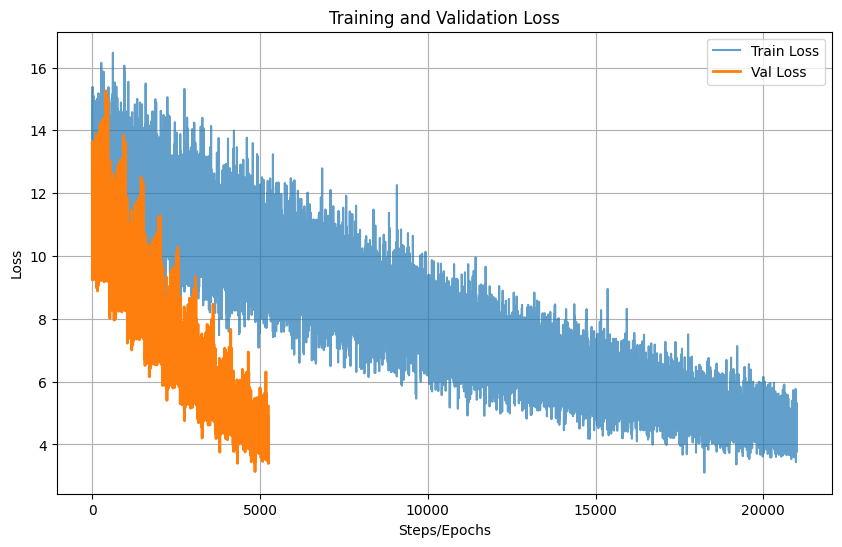

In [43]:
trained_model.plot_losses()

## Word Embedding Results

In [44]:
params = list(trained_model.parameters())
word_vectors = params[0].detach()

In [45]:
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

for word in word_dict:
    print(word,word_dict[word])

animal tensor([-0.9114,  0.0846])
boy tensor([-0.2324, -0.4547])
castle tensor([-0.5723,  0.6325])
cat tensor([-0.7571,  0.3909])
country tensor([ 0.5287, -0.8694])
crown tensor([ 0.3335, -0.2604])
dog tensor([ 0.3717, -0.1566])
empire tensor([0.2181, 0.0628])
family tensor([-0.4791,  0.6581])
father tensor([0.1791, 0.1178])
girl tensor([-0.5071, -0.4124])
house tensor([0.1349, 0.0428])
king tensor([ 3.1304, -1.6172])
marriage tensor([ 0.9108, -0.1884])
mother tensor([ 0.8496, -0.1049])
pet tensor([1.1320, 0.1700])
play tensor([-0.0423, -0.4104])
queen tensor([-0.6240,  0.0521])
rule tensor([-0.0973, -0.0484])
sleep tensor([ 0.6867, -0.3806])


In [46]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

for word in unique_words:
    print(word,[x[0] for x in most_similar(word,word_dict)])

animal ['queen', 'cat', 'rule', 'castle', 'girl']
boy ['play', 'girl', 'rule', 'country', 'queen']
castle ['family', 'cat', 'animal', 'queen', 'rule']
cat ['castle', 'animal', 'queen', 'family', 'rule']
country ['crown', 'sleep', 'king', 'dog', 'play']
crown ['sleep', 'king', 'dog', 'country', 'marriage']
dog ['king', 'sleep', 'marriage', 'crown', 'mother']
empire ['house', 'pet', 'father', 'mother', 'marriage']
family ['castle', 'cat', 'animal', 'queen', 'rule']
father ['house', 'empire', 'pet', 'mother', 'marriage']
girl ['rule', 'boy', 'queen', 'animal', 'play']
house ['empire', 'pet', 'father', 'mother', 'marriage']
king ['sleep', 'dog', 'crown', 'marriage', 'mother']
marriage ['mother', 'dog', 'king', 'sleep', 'pet']
mother ['marriage', 'pet', 'dog', 'king', 'sleep']
pet ['empire', 'house', 'mother', 'marriage', 'father']
play ['boy', 'country', 'girl', 'rule', 'crown']
queen ['animal', 'cat', 'rule', 'castle', 'girl']
rule ['girl', 'queen', 'animal', 'boy', 'cat']
sleep ['king', 

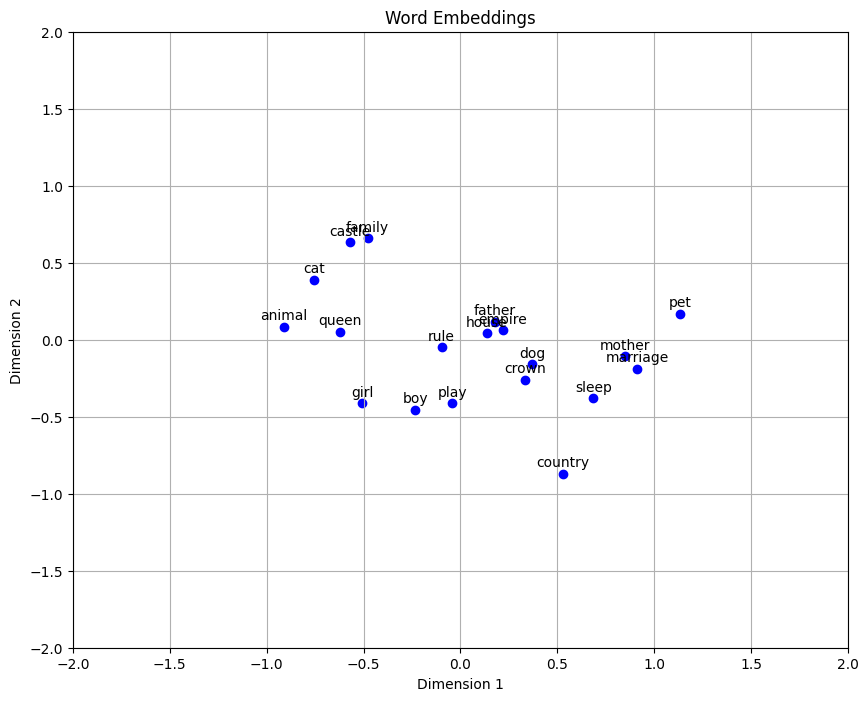

In [47]:
x_coords, y_coords = zip(*[word_dict[word].numpy() for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()